In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd /content/gdrive/MyDrive/Colab Notebooks/11 - Deep Learning/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks/11 - Deep Learning


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lib.reg_utils import sigmoid, relu, plot_decision_boundary, initialize_parameters, load_2D_dataset, predict_dec
from lib.reg_utils import compute_cost, predict, forward_propagation, backward_propagation, update_parameters
import sklearn
import sklearn.datasets
import scipy.io
from lib.testCases import *

plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

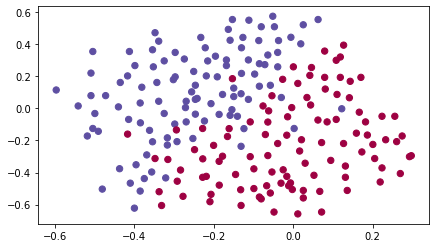

In [ ]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

# Non-regularized model


In [ ]:
def forward_propagation(X, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    cache = (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3)
    return A3, cache

def compute_cost(a3, Y):
    m = Y.shape[1]
    logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
    cost = 1./ m * np.nansum(logprobs)
    return cost

def backward_propagation(X, Y, cache):
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0)) # 0 if negative
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,
                 "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
                 "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [ ]:
def model(X, Y, learning_rate=0.3, num_iterations=30000, print_cost=True, lambd=0, keep_prob=1):
        
    grads, costs = {}, []                        
    m = X.shape[1]
    layers_dims = [X.shape[0], 20, 3, 1]
    
    # Initialize parameters dictionary.
    parameters = initialize_parameters(layers_dims)

    for i in range(0, num_iterations):
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        # Cost function
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
        
        # Backward propagation.
        # only regularization or dropout
        assert(lambd == 0 or keep_prob == 1)
        
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 10000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.6557412523481002
Cost after iteration 10000: 0.1632998752572419
Cost after iteration 20000: 0.13851642423259714


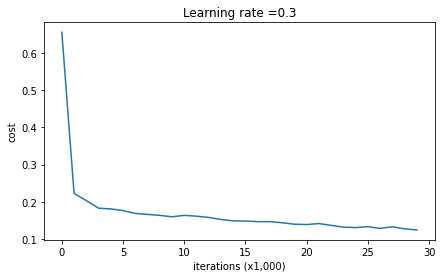

On the training set:
Accuracy: 0.9478672985781991
On the test set:
Accuracy: 0.915


In [ ]:
# without regularization
parameters = model(train_X, train_Y)
print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

The train accuracy is 94.8% while the test accuracy is 91.5%. This is the **baseline model** (you will observe the impact of regularization on this model). Run the following code to plot the decision boundary of your model.

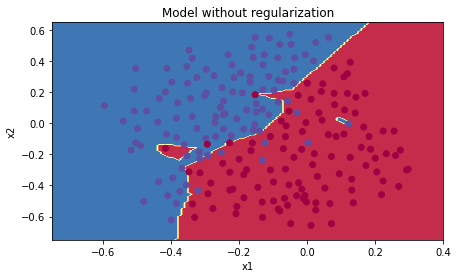

In [ ]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

The non-regularized model is obviously overfitting the training set. It is fitting the noisy points! Lets now look at two techniques to reduce overfitting.

# L2 Regularization

https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd

The standard way to avoid overfitting is called **L2 regularization**. It consists of appropriately modifying your cost function, from:
$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small  y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} \tag{1}$$
To:
$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} \tag{2}$$

In [ ]:
def compute_cost_with_regularization(A3, Y, parameters, lambd):
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    # compute cost
    cross_entropy_cost = compute_cost(A3, Y)
    L2_regularization_cost = lambd /(2*m)*(np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)))    
    cost = cross_entropy_cost + L2_regularization_cost
    return cost

In [ ]:
A3, Y_assess, parameters = compute_cost_with_regularization_test_case()
compute_cost_with_regularization(A3, Y_assess, parameters, lambd = 0.1)

1.7864859451590758

In [ ]:
def backward_propagation_with_regularization(X, Y, cache, lambd):
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T) + (lambd/m) * W3
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T) + (lambd/m) * W2
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T) + (lambd/m) * W1
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [ ]:
X_assess, Y_assess, cache = backward_propagation_with_regularization_test_case()

grads = backward_propagation_with_regularization(X_assess, Y_assess, cache, lambd=0.7)
print ("dW1 = \n"+ str(grads["dW1"]))
print ("dW2 = \n"+ str(grads["dW2"]))
print ("dW3 = \n"+ str(grads["dW3"]))

dW1 = 
[[-0.25604646  0.12298827 -0.28297129]
 [-0.17706303  0.34536094 -0.4410571 ]]
dW2 = 
[[ 0.79276486  0.85133918]
 [-0.0957219  -0.01720463]
 [-0.13100772 -0.03750433]]
dW3 = 
[[-1.77691347 -0.11832879 -0.09397446]]


Cost after iteration 0: 0.6974484493131264
Cost after iteration 10000: 0.2684918873282239
Cost after iteration 20000: 0.26809163371273004


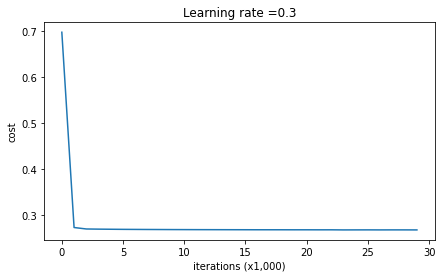

On the train set:
Accuracy: 0.9383886255924171
On the test set:
Accuracy: 0.93


In [ ]:
parameters = model(train_X, train_Y, lambd = 0.7)
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

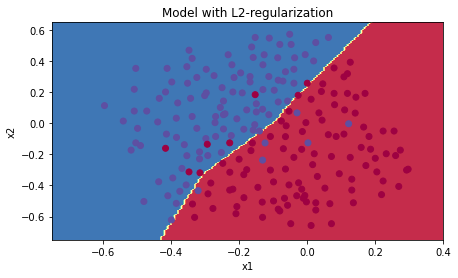

In [ ]:
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

**Observations**:
- The value of $\lambda$ is a hyperparameter that you can tune using a dev set.
- L2 regularization makes your decision boundary smoother. If $\lambda$ is too large, it is also possible to "oversmooth", resulting in a model with high bias.

**What is L2-regularization actually doing?**:

L2-regularization relies on the assumption that a model with small weights is simpler than a model with large weights. Thus, by penalizing the square values of the weights in the cost function you drive all the weights to smaller values. It becomes too costly for the cost to have large weights! This leads to a smoother model in which the output changes more slowly as the input changes. 

**What you should remember** -- the implications of L2-regularization on:
- The cost computation:
    - A regularization term is added to the cost
- The backpropagation function:
    - There are extra terms in the gradients with respect to weight matrices
- Weights end up smaller ("weight decay"): 
    - Weights are pushed to smaller values.

# Dropout

<!--
To understand drop-out, consider this conversation with a friend:
- Friend: "Why do you need all these neurons to train your network and classify images?". 
- You: "Because each neuron contains a weight and can learn specific features/details/shape of an image. The more neurons I have, the more featurse my model learns!"
- Friend: "I see, but are you sure that your neurons are learning different features and not all the same features?"
- You: "Good point... Neurons in the same layer actually don't talk to each other. It should be definitly possible that they learn the same image features/shapes/forms/details... which would be redundant. There should be a solution."
!--> 

When you shut some neurons down, you actually modify your model. The idea behind drop-out is that at each iteration, you train a different model that uses only a subset of your neurons. With dropout, your neurons thus become less sensitive to the activation of one other specific neuron, because that other neuron might be shut down at any time. 

## Forward propagation with dropout

**Hint:** Let's say that keep_prob = 0.8, which means that we want to keep about 80% of the neurons and drop out about 20% of them.  We want to generate a vector that has 1's and 0's, where about 80% of them are 1 and about 20% are 0.
This python statement:  
`X = (X < keep_prob).astype(int)`  
is conceptually the same as this if-else statement (for the simple case of a one-dimensional array) :

Set $A^{[1]}$ to $A^{[1]} * D^{[1]}$. (You are shutting down some neurons). You can think of $D^{[1]}$ as a mask, so that when it is multiplied with another matrix, it shuts down some of the values.

Divide $A^{[1]}$ by `keep_prob`. By doing this you are assuring that the result of the cost will still have the same expected value as without drop-out. (This technique is also called inverted dropout.)

In [ ]:
def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5):    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
 
    D1 = np.random.rand(A1.shape[0], A1.shape[1])                                        
    D1 = (D1 < keep_prob)                                         
    A1 = A1 * D1                                         
    A1 = A1 / keep_prob  
    
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    
    D2 = np.random.rand(A2.shape[0], A2.shape[1])                                        
    D2 = (D2 < keep_prob)                                         
    A2 = A2*D2                                         
    A2 = A2/keep_prob                                    

    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

In [ ]:
X_assess, parameters = forward_propagation_with_dropout_test_case()

A3, cache = forward_propagation_with_dropout(X_assess, parameters, keep_prob = 0.7)
print ("A3 = " + str(A3))

A3 = [[3.69747206e-01 2.93815585e-04 4.96833893e-01 1.44689281e-02
  4.96833893e-01]]


## Backward propagation with dropout

**Instruction**:
Backpropagation with dropout is actually quite easy. You will have to carry out 2 Steps:
1. You had previously shut down some neurons during forward propagation, by applying a mask $D^{[1]}$ to `A1`. In backpropagation, you will have to shut down the same neurons, by reapplying the same mask $D^{[1]}$ to `dA1`. 
2. During forward propagation, you had divided `A1` by `keep_prob`. In backpropagation, you'll therefore have to divide `dA1` by `keep_prob` again (the calculus interpretation is that if $A^{[1]}$ is scaled by `keep_prob`, then its derivative $dA^{[1]}$ is also scaled by the same `keep_prob`).


In [ ]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    dA2 = np.dot(W3.T, dZ3)
    
    # apply mask to shut down the same neuron
    dA2 = dA2*D2              
    dA2 = dA2/keep_prob
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dA1 = dA1*D1             
    dA1 = dA1/keep_prob             
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [ ]:
X_assess, Y_assess, cache = backward_propagation_with_dropout_test_case()
gradients = backward_propagation_with_dropout(X_assess, Y_assess, cache, keep_prob = 0.8)

print ("dA1 = \n" + str(gradients["dA1"]))
print ("dA2 = \n" + str(gradients["dA2"]))

dA1 = 
[[ 0.36544439  0.         -0.00188233  0.         -0.17408748]
 [ 0.65515713  0.         -0.00337459  0.         -0.        ]]
dA2 = 
[[ 0.58180856  0.         -0.00299679  0.         -0.27715731]
 [ 0.          0.53159854 -0.          0.53159854 -0.34089673]
 [ 0.          0.         -0.00292733  0.         -0.        ]]


Cost after iteration 0: 0.6579307804914392
Cost after iteration 10000: 0.20532740528657992
Cost after iteration 20000: 0.18147395648863265


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply


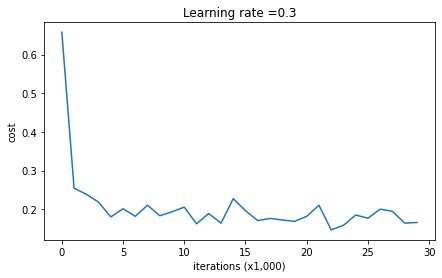

On the train set:
Accuracy: 0.943127962085308
On the test set:
Accuracy: 0.94


In [ ]:
parameters = model(train_X, train_Y, keep_prob = 0.86, learning_rate = 0.3)

print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

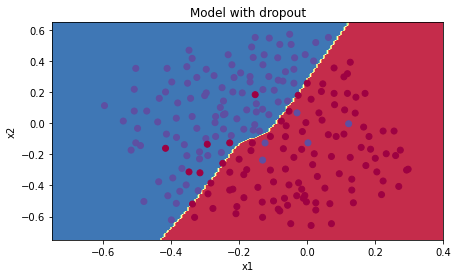

In [ ]:
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

**Note**:
- A **common mistake** when using dropout is to use it both in training and testing. You should use dropout (randomly eliminate nodes) only in training. 
- Deep learning frameworks like [tensorflow](https://www.tensorflow.org/api_docs/python/tf/nn/dropout), [PaddlePaddle](http://doc.paddlepaddle.org/release_doc/0.9.0/doc/ui/api/trainer_config_helpers/attrs.html), [keras](https://keras.io/layers/core/#dropout) or [caffe](http://caffe.berkeleyvision.org/tutorial/layers/dropout.html) come with a dropout layer implementation. Don't stress - you will soon learn some of these frameworks.

<b>What you should remember about dropout:<b/>

- Dropout is a regularization technique.
- You only use dropout during training. Don't use dropout (randomly eliminate nodes) during test time.
- Apply dropout both during forward and backward propagation.
- During training time, divide each dropout layer by keep_prob to keep the same expected value for the activations. For example, if keep_prob is 0.5, then we will on average shut down half the nodes, so the output will be scaled by 0.5 since only the remaining half are contributing to the solution. Dividing by 0.5 is equivalent to multiplying by 2. Hence, the output now has the same expected value. You can check that this works even when keep_prob is other values than 0.5.  

# Conclusions

**Here are the results of our three models**: 

<table> 
    <tr>
        <td>
        **model**
        </td>
        <td>
        **train accuracy**
        </td>
        <td>
        **test accuracy**
        </td>
    </tr>
    <tr>
        <td>
        3-layer NN without regularization
        </td>
        <td>
        95%
        </td>
        <td>
        91.5%
        </td>
    <tr>
        <td>
        3-layer NN with L2-regularization
        </td>
        <td>
        94%
        </td>
        <td>
        93%
        </td>
    </tr>
    <tr>
        <td>
        3-layer NN with dropout
        </td>
        <td>
        93%
        </td>
        <td>
        95%
        </td>
    </tr>
</table> 

Note that regularization hurts training set performance! This is because it limits the ability of the network to overfit to the training set. But since it ultimately gives better test accuracy, it is helping your system. 

<b>What we want you to remember from this notebook<b/>:
    
- Regularization will help you reduce overfitting.
- Regularization will drive your weights to lower values.
- L2 regularization and Dropout are two very effective regularization techniques.